# Decision trees
## Pro:
1. computationally cheap
2. easy for humans to understand result
3. missing values ok
4. can deal with irrelevant features

## Con:
Prone to overfitting

## Works with:
Numeric values, Nomial values

## Prepare data
quantize continuous values

## Split subsets
split in a way that gives most information gain, by calculating Shannon entropy

### 1. calculate entropy and generate dataset

In [1]:
# we need a function to calculate shannon entropy

from math import log
import numpy as np

def calcShannonEnt (dataSet) :
    numEntries = len(dataSet)
    labelCounts = {}
    for featVec in dataSet:
        currentLabel = featVec[-1]
        if currentLabel not in labelCounts.keys():
            labelCounts[currentLabel] = 0
        labelCounts[currentLabel] += 1
    shannonEnt = 0.0
    for key in labelCounts:
        prob = float(labelCounts[key])/numEntries
        shannonEnt -= prob * log(prob, 2)
    return shannonEnt

In [2]:
def createDataSet():
    dataSet = np.array([[1, 1, 'yes'],
               [1, 1, 'yes'],
               [1, 0, 'no'],
               [0, 1, 'no'],
               [0, 1, 'no']])
    labels = ['no surfacing', 'flippers']
    return dataSet, labels

### 2. splitting dataset

In [3]:
def splitDataSet(dataSet, axis, value):
    # todo: change hard-coded 2
    columnsNum = len(dataSet[0]) - 1
    retDataSet = np.zeros((0, columnsNum))
    for featVec in dataSet:
        if featVec[axis] == value:
            featVec = np.delete(featVec, axis).reshape((1,columnsNum))
            retDataSet = np.concatenate((retDataSet, featVec))
    return retDataSet

### 3. choose the best feature to split on

In [4]:
def chooseBestFeatureToSplit(dataSet):
    numFeatures = np.size(dataSet, 1) - 1
    baseEntropy = calcShannonEnt(dataSet)
    bestInfoGain = 0.0; bestFeature = -1
    for i in range(numFeatures):
        featList = [example[i] for example in dataSet]
        uniqueVals = set(featList)
        newEntropy = 0.0
        for value in uniqueVals:
            subDataSet = splitDataSet(dataSet, i, value)
            prob = len(subDataSet)/float(len(dataSet))
            newEntropy += prob * calcShannonEnt(subDataSet)
        infoGain = baseEntropy - newEntropy
        if (infoGain > bestInfoGain):
            bestInfoGain = infoGain
            bestFeature = i
    return bestFeature

### 4. create tree
what if we ran out of attributes and the labels are not the same?
Take a majority vote

In [5]:
import operator

def majorityCnt(classList):
    classCount = {}
    for vote in classList:
        if vote not in classCount.keys(): classCount[vote] = 0
        classCount[vote] += 1
    sortedClassCount = sorted(classCount.iteritems(),
        key = operator.itemgetter(1), reverse = True)
    return sortedClassCount[0][0]

build a tree

In [6]:
def createTree(dataSet, labels):
    classList = [example[-1] for example in dataSet]
    if classList.count(classList[0]) == len(classList):
        return classList[0]
    if len(dataSet[0]) == 1:
        return majorityCnt(classList)
    bestFeat = chooseBestFeatureToSplit(dataSet)
    bestFeatLabel = labels[bestFeat]
    myTree = {bestFeatLabel: {}}
    del(labels[bestFeat])
    featValues = [example[bestFeat] for example in dataSet]
    uniqueVals = set(featValues)
    for value in uniqueVals:
        subLabels = labels[:]
        myTree[bestFeatLabel][value] = createTree(splitDataSet\
                                    (dataSet, bestFeat, value), subLabels)
    return myTree

In [7]:
myDat, labels = createDataSet()
myTree = createTree(myDat, labels)

### 5. draw tree

In [8]:
import matplotlib.pyplot as plt

decisionNode = dict(boxstyle="sawtooth", fc="0.8")
leafNode = dict(boxstyle ="round4", fc="0.8")
arrow_args = dict(arrowstyle="<-")

def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    createPlot.axl.annotate(nodeTxt, xy=parentPt,
        xycoords='axes fraction',
        xytext=centerPt, textcoords='axes fraction',
        va='center', ha='center', bbox=nodeType, arrowprops=arrow_args)
def createPlot():
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    createPlot.axl = plt.subplot(111, frameon=False)
    plotNode("a decision node", (0.5, 0.1), (0.1, 0.5), decisionNode)
    plotNode("a leaf node", (0.9, 0.1), (0.3, 0.8), leafNode)
    plt.show()

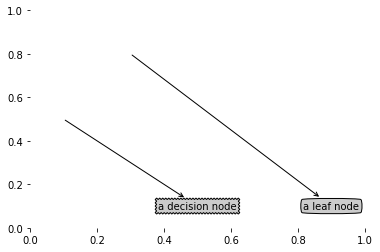

In [9]:
createPlot()

In [10]:
# to draw tree better, we need to know the depth and 
# number of leaf nodes of the tree
def getNumLeafs(myTree):
    numLeafs = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':
            numLeafs += getNumLeafs(secondDict[key])
        else: numLeafs +=1
    return numLeafs

def getTreeDepth(myTree):
    maxDepth = 0;
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else: thisDepth = 1
        if thisDepth > maxDepth: maxDepth = thisDepth
    return maxDepth

In [11]:
# just a helper function for testing, can be deleted in future
def retrieveTree(i):
    listOfTrees = [{'no surfacing': {'1': {'flippers': \
                    {'1': 'yes', '0': 'no'}}, '0': 'no'}},
                  {'no surfacing': {'1': {'flippers': \
                    {'1': 'no', '0': {'head': {0:'no', 1: 'yes'}}}}, '0': 'no'}}]
    return listOfTrees[i]

In [12]:
getNumLeafs(retrieveTree(1))

4

In [13]:
getNumLeafs(retrieveTree(0))

3

In [14]:
getTreeDepth(retrieveTree(1))

3

In [15]:
getTreeDepth(retrieveTree(0))

2

In [16]:
# plote complete tree
def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0] - cntrPt[0])/2.0 + cntrPt[0]
    yMid = (parentPt[1] - cntrPt[1])/2.0 + cntrPt[1]
    createPlot.axl.text(xMid, yMid, txtString)
def plotTree(myTree, parentPt, nodeTxt):
    numLeafs = getNumLeafs(myTree)
    getTreeDepth(myTree)
    firstStr = list(myTree.keys())[0]
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs))/2.0/plotTree.totalW,\
             plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt)
    plotNode(firstStr, cntrPt, parentPt, decisionNode)
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            plotTree(secondDict[key], cntrPt, str(key))
        else:
            plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff),
                    cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD
    
def createPlot(inTree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.axl = plt.subplot(111, frameon=False, **axprops)
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5/plotTree.totalW; plotTree.yOff = 1.0;
    plotTree(inTree, (0.5, 1.0), '')
    plt.show()
    

In [17]:
myTree = retrieveTree(0)

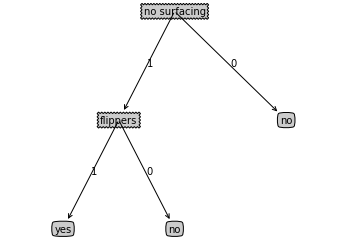

In [18]:
createPlot(myTree)

In [19]:
myTree

{'no surfacing': {'1': {'flippers': {'1': 'yes', '0': 'no'}}, '0': 'no'}}

### 6. classify

In [20]:
def classify(inputTree, featLabels, testVec):
    firstStr = list(inputTree.keys())[0]
    secondDict = inputTree[firstStr]
    featIndex = featLabels.index(firstStr)
    classLabel = ''
    for key in secondDict.keys():
        if testVec[featIndex] == key:
            if type(secondDict[key]).__name__=='dict':
                classLabel = classify(secondDict[key], featLabels, testVec)
            else: classLabel = secondDict[key]
    return classLabel

In [21]:
myDat, labels = createDataSet()

In [22]:
cplabels = labels[:]
myDat

array([['1', '1', 'yes'],
       ['1', '1', 'yes'],
       ['1', '0', 'no'],
       ['0', '1', 'no'],
       ['0', '1', 'no']], dtype='<U21')

In [23]:
myTree = createTree(myDat, cplabels)

In [24]:
classify(myTree, labels, ['0','1'])

'no'

In [25]:
myDat

array([['1', '1', 'yes'],
       ['1', '1', 'yes'],
       ['1', '0', 'no'],
       ['0', '1', 'no'],
       ['0', '1', 'no']], dtype='<U21')

### 7. example: lenses

In [26]:
import pandas as pd
column_names = ["age", "spectacle", "astigmatic", "tear", "label"]
raw_data = pd.read_csv("./data/lenses.data", delim_whitespace=True, header=None, names=column_names)

In [41]:
print(raw_data.head())
raw_data = raw_data.sample(frac=1)
train_data = raw_data[:len(raw_data)*9 // 10]
test_data = raw_data[len(raw_data)*9 // 10:]

    age  spectacle  astigmatic  tear  label
20    3          1           2     2      1
16    2          2           2     2      3
3     1          1           2     1      3
4     1          1           2     2      1
18    3          1           1     2      3


In [42]:
test_data

,age,spectacle,astigmatic,tear,label
17,3,1,1,1,3
15,2,2,2,1,3
14,2,2,1,2,2


In [43]:
myDat, labels = train_data, train_data.columns[:-1]
cplabels = list(labels)

In [44]:
myTree = createTree(myDat.to_numpy(), cplabels)

In [45]:
for index, data in test_data.iterrows():
    print(classify(myTree, list(labels), data))

3.0
3.0
2.0


In [46]:
myTree

{'tear': {1: 3.0,
  2: {'astigmatic': {1.0: {'age': {1.0: 2.0,
      2.0: 2.0,
      3.0: {'spectacle': {1.0: 3.0, 2.0: 2.0}}}},
    2.0: {'spectacle': {1.0: 1.0,
      2.0: {'age': {1.0: 1.0, 2.0: 3.0, 3.0: 3.0}}}}}}}}

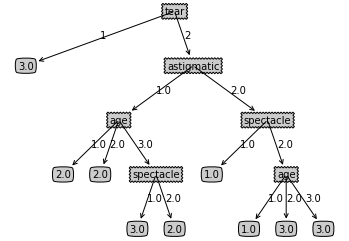

In [47]:
createPlot(myTree)

In [48]:
myDat

,age,spectacle,astigmatic,tear,label
21,3,2,1,1,3
18,3,1,1,2,3
11,2,1,2,1,3
5,1,2,1,1,3
19,3,1,2,1,3
7,1,2,2,1,3
22,3,2,1,2,2
6,1,2,1,2,2
2,1,1,1,2,2
16,2,2,2,2,3
